In [1]:
# %% import package to use
import datatable
import pandas as pd
from IPython.display import display
import numpy as np
import os
from sklearn.metrics import accuracy_score
from imblearn.metrics import sensitivity_specificity_support
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
import xgboost as xgb
pd.set_option('display.max_columns', None)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score

In [2]:
import pickle

#### XGBoost
with open('../asthma_xg_classifier_spcut.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['mean_mse'] == df_results_xg['mean_mse'].min()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores', 'mse_loss']].reset_index(drop=True)

In [3]:
# %% Load dataset
DATA_PATH = "/home/lkh256/Studio/Asthma"
df_init = datatable.fread(os.path.join(DATA_PATH, 'dataset.csv'), 
                          encoding='utf-8-sig', 
                          na_strings=['', 'NA']).to_pandas()

df_init['sp_cut'] = np.where(df_init['sp_eosinophil'] > 3, 1, 0)

print("Number of samples = {}".format(len(df_init)))

# %% Check missings
print("Check their is any missing variables in dataset: \n", df_init.isnull().sum())

# %%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_init,  
                                       random_state=1004, 
                                       stratify=df_init['sp_cut'], 
                                       test_size=0.2)

print("Train set size = {}".format(len(train_set)))
print("Test set size = {}".format(len(test_set)))

feature_mask = ['age', 'sex', 'FeNO', 'Bl_eos_count']

X_train = train_set[feature_mask].values
y_train = train_set['sp_cut'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['sp_cut'].values
dtest = xgb.DMatrix(X_test, label=y_test)


Number of samples = 756
Check their is any missing variables in dataset: 
 age                       0
sex                       0
Squamouscell              0
Marcrophage               0
Neutrophil                0
sp_eosinophil             0
Other                     0
Epithelialcell            0
salineFVC                 0
80%FEV1                   0
PC20_mgpml              287
maxFall_FEV1_percent    136
FeNO                      1
dyspnea                   3
cough                     3
wheezing                  4
rhinitis                  2
smoking                 184
IgE                     333
FEV1_0_percent            1
FVC_afterMBPT             2
FEV1_afterMBPT            2
FEF2575_afterMBPT         3
FEV1_FVC_0                0
Bl_eos_count            296
BMI                     628
mbpt                      0
asthma                    0
sp_cut                    0
dtype: int64
Train set size = 604
Test set size = 152


## XGBoost

In [4]:
xg_best_param.head(1)

,max_depth,learning_rate,lambda,gamma,scores,mse_loss
0,3,0.001,3,0.1,0.859504,0.367583


In [5]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 3,
          'lambda': 3,
          'gamma': 0.1}

model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

In [6]:
test_set['sp_cut'].value_counts(normalize=True)

0    0.657895
1    0.342105
Name: sp_cut, dtype: float64

In [7]:
print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

Train accuracy 0.8857615894039735
Test accuracy 0.8026315789473685
Train neg_loss :  0.30245419476329294
Test neg_loss 0.4542851279930849


# Visualization

In [8]:
def plot_roc_prc(y_hat, y):
    fpr, tpr, _ = roc_curve(y, y_hat, pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    prec, recall, _ = precision_recall_curve(y, y_hat, pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

Accuracy: 0.8026315789473685
Sensitivity: 0.6153846153846154
Specificity: 0.9
AUROC: 0.8564423076923077


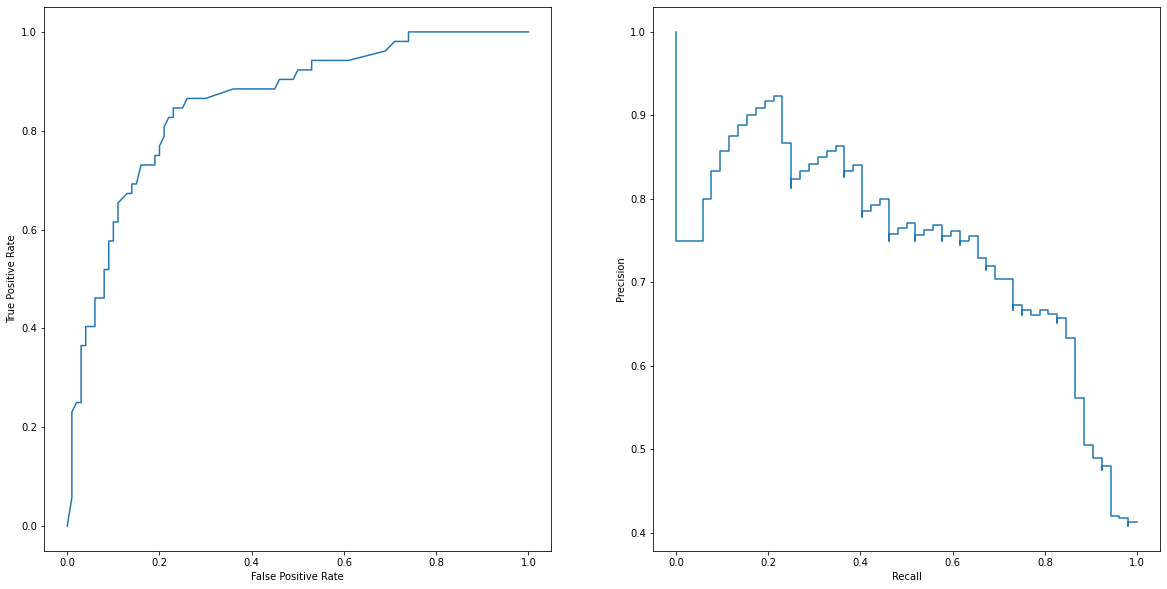

In [9]:
y_hat = model_xgb.predict(dtest)

accuracy = accuracy_score(y_pred=(y_hat > 0.5), y_true=y_test)
sensitivity, specificity, _ = sensitivity_specificity_support(y_true=y_test, y_pred=(y_hat > 0.5), average='binary')

print("Accuracy: {}".format(accuracy))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))        
print("AUROC: {}".format(roc_auc_score(y_test, y_hat)))
plot_roc_prc(y_hat, y_test)

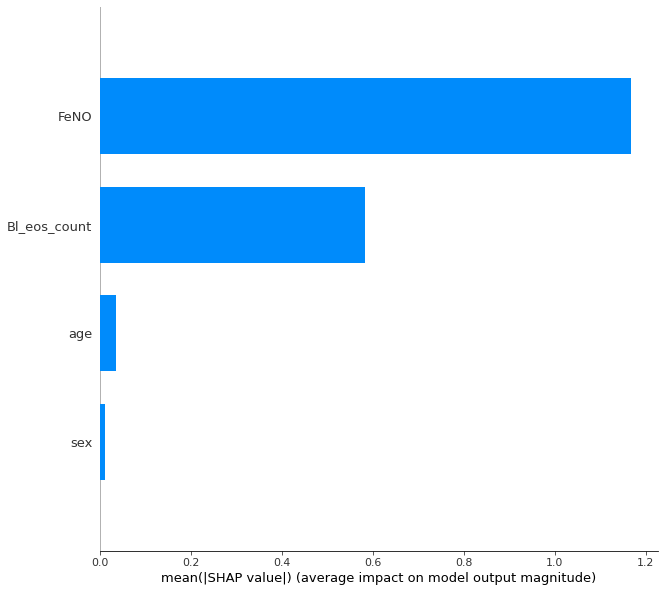

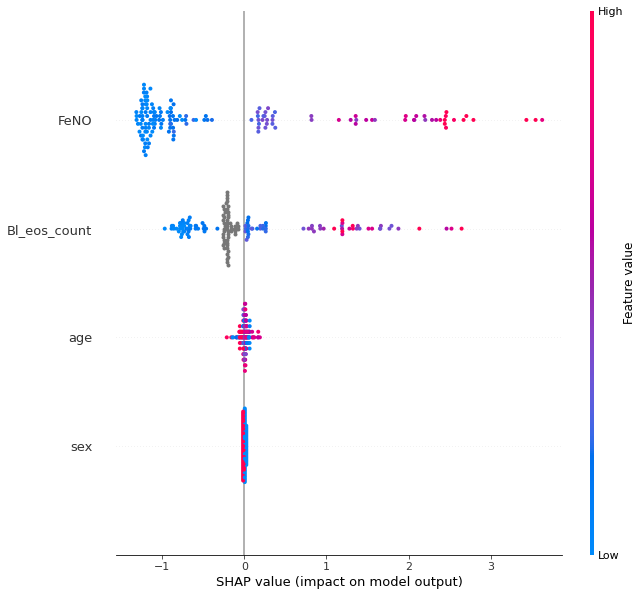

In [10]:
import shap

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))